In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm, ensemble, linear_model
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix,matthews_corrcoef
from sklearn.decomposition import PCA

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import joblib
import warnings

In [3]:
# Carga de datos
DATA_PATH = '/data/sespinoza/objetivo3/1-experimento/'
all_cancers = pd.read_csv( DATA_PATH + 'all_cancers-2-ver.csv', header=0, sep=',', encoding='utf-8')
data_peru = pd.read_csv(DATA_PATH + 'data_peru-final.csv', header=0, sep=',', encoding='utf-8')

In [4]:
print(all_cancers.shape)
print(data_peru.shape)

(6987, 19966)
(69, 19966)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, nb_input):
        super(MLP, self).__init__()
        
        # Definimos las capas
        self.gaussian_noise_std = 0.1  # Ajusta el valor de ruido gaussiano
        self.fc1 = nn.Linear(nb_input, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 3)
        
    def forward(self, x):
        # Agregar ruido gaussiano manualmente
        if self.training:  # Solo agrega ruido en modo de entrenamiento
            noise = torch.randn_like(x) * self.gaussian_noise_std
            x = x + noise
            
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.softmax(self.output_layer(x), dim=1)  # Usamos softmax en la capa de salida
        return x

In [6]:
classifiers = {
    'SVM Linear': {
        'model': svm.SVC(kernel='linear'),
        'params': {'svm_linear__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    },
    'SVM RBF': {
        'model': svm.SVC(kernel='rbf'),
        'params': {
            'svm_rbf__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'svm_rbf__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto']
        }
    },
    'Logistic Regression': {
        'model': linear_model.LogisticRegression(max_iter=1000, solver='liblinear'),
        'params': {
            'logistic_regression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'logistic_regression__penalty': ['l1', 'l2']
        }
    },
    'Random Forest': {
        'model': ensemble.RandomForestClassifier(random_state=42),
        'params': {
            'random_forest__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'random_forest__max_depth': [None, 5, 10, 20],
            'random_forest__min_samples_split': [2, 5, 10]
        }
    },
    'Boosting': {
        'model': ensemble.AdaBoostClassifier(random_state=42),
        'params': {
            'boosting__n_estimators': [10, 20, 30, 50, 70, 100, 150, 200, 400],
            'boosting__learning_rate': [0.01, 0.1, 1]
        }
    }
}

In [7]:
import joblib

# Ruta del archivo .pkl
file_path = 'best_params_reconstructed.pkl'

# Cargar el archivo .pkl
best_params = joblib.load(file_path)

In [8]:
# Separar características y etiquetas del conjunto de entrenamiento
X = all_cancers.drop('labels', axis=1)
y = all_cancers['labels']

In [9]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [10]:
# **Entrenamiento de Modelos Finales**
from sklearn.decomposition import PCA

# Realiza la selección de características en todo el conjunto de entrenamiento
MI = mutual_info_classif(X_scaled, y)
n_features_mi = 1000
selected_scores_indices = np.argsort(MI)[::-1][:n_features_mi]
X_mi = X_scaled.iloc[:, selected_scores_indices]

estimator = linear_model.LogisticRegression(max_iter=700, solver='liblinear')
n_features_rfe = 100
rfe = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe.fit(X_mi, y)
X_selected = rfe.transform(X_mi)
X_final=X_selected

In [11]:
# Entrenar los modelos finales
# **Análisis de Resultados**
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef,roc_auc_score
from collections import Counter
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
final_models = {}
for name, clf_info in classifiers.items():
    model = clf_info['model']
    # Obtener los mejores hiperparámetros
    param_counts = Counter(tuple(sorted(params.items())) for params in best_params[name])
    most_common_params = dict(param_counts.most_common(1)[0][0])

    # Crear pipeline con el modelo
    pipeline = Pipeline([
        (name.lower().replace(' ', '_'), model)
    ])

    # Establecer los hiperparámetros utilizando los nombres completos
    pipeline.set_params(**most_common_params)
    pipeline.fit(X_final, y)
    final_models[name] = pipeline
    # Guardar el modelo
    joblib.dump(pipeline, f'final_{name.lower().replace(" ", "_")}_model.pkl')

# Entrenar el modelo final de la Red Neuronal
# Preparar los datos para PyTorch
X_tensor = torch.tensor(X_final, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Instanciar el modelo MLP
mlp = MLP(nb_input=X_final.shape[1])  # Asegúrate de que ya tienes la definición de MLP en PyTorch
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Entrenar el modelo final de la Red Neuronal
epochs = 100
mlp.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = mlp(inputs)  # Hacer una pasada de forward
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar los pesos

        running_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Guardar el modelo entrenado
torch.save(mlp.state_dict(), 'final_neural_network_model.pth')
final_models['Neural Network'] = mlp

/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Epoch [10/100], Loss: 0.6791
Epoch [20/100], Loss: 0.6448
Epoch [30/100], Loss: 0.6403
Epoch [40/100], Loss: 0.6366
Epoch [50/100], Loss: 0.6380
Epoch [60/100], Loss: 0.6356
Epoch [70/100], Loss: 0.6369
Epoch [80/100], Loss: 0.6322
Epoch [90/100], Loss: 0.6314
Epoch [100/100], Loss: 0.6196


In [12]:
def predict_pytorch(model, data):
    model.eval()  # Cambiar a modo evaluación
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        inputs = torch.tensor(data, dtype=torch.float32)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con la mayor probabilidad
    return predicted.numpy()

In [13]:
data_peru

,LOC101928626,LINC01128,LOC284600,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,LINC01342,TTLL10,...,CPT1B,CHKB,MAFIP,MSH5,LOC389831,FAM230C,LOC389834,LOC283788,FRG1CP,labels
0,5.405768,7.105810,6.407605,6.751036,6.423195,6.509502,6.651562,7.064638,5.995642,6.327105,...,6.501750,6.907690,8.422326,6.115378,6.888611,5.007248,8.925795,8.068007,6.872607,0
1,4.159188,6.299034,6.178953,6.465379,6.308839,6.390281,6.867204,6.849003,5.681353,6.067419,...,6.614204,7.139718,7.682306,7.396560,8.341874,4.919640,8.281252,8.078099,6.560089,0
2,4.811373,6.420369,6.110383,6.702332,6.452215,6.426228,7.000279,7.037242,5.676338,6.306445,...,6.688823,7.212832,7.194405,7.307553,7.984998,4.998576,7.792717,7.839151,6.482906,0
3,5.120837,6.470795,6.181780,6.514313,6.229662,6.400035,6.639504,7.451014,5.473437,6.110803,...,6.650639,7.291541,8.605102,7.140464,8.833814,4.915654,8.994024,7.948627,6.532978,0
4,4.678503,7.015001,6.299136,6.690043,6.372549,6.594241,6.670578,7.020186,5.861442,6.309986,...,6.602375,7.211246,8.250206,6.661626,7.212454,4.834216,8.829757,8.220692,7.079568,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,4.300831,6.799858,6.132306,6.694394,6.234502,6.390698,6.624664,6.719779,5.541144,6.132209,...,6.350879,7.008382,7.731767,6.853608,7.249560,4.971040,8.180356,7.914202,6.712507,1
65,4.933752,7.209855,6.134703,6.799384,6.372639,6.534240,6.775209,6.809262,5.995258,6.227656,...,6.566923,7.070441,7.626210,6.467202,7.472178,4.965690,8.102796,7.944149,6.956125,1
66,4.809190,6.608746,6.249217,6.789390,6.510175,6.566593,6.925290,6.907346,5.682360,6.334061,...,6.426555,7.026294,8.011013,6.447739,7.064877,4.960135,8.575175,7.802760,6.692546,1
67,4.590937,7.321604,6.349540,6.746459,6.456240,6.543193,6.818618,6.847280,5.798905,6.306778,...,6.502476,7.075977,7.967216,6.311019,6.067004,4.752972,8.623297,7.743439,6.548646,1


In [14]:
all_cancers

,LOC101928626,LINC01128,LOC284600,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,LINC01342,TTLL10,...,CPT1B,CHKB,MAFIP,MSH5,LOC389831,FAM230C,LOC389834,LOC283788,FRG1CP,labels
0,3.749618,8.077550,4.793906,6.505880,5.438233,5.884130,10.101129,5.795863,5.561319,4.678109,...,6.887132,8.275471,5.435578,6.734288,7.552173,3.206443,5.712946,3.053422,8.050995,2
1,3.571473,7.654215,4.688264,6.469496,5.577384,6.023885,7.499779,5.522820,5.509706,4.431010,...,6.225518,8.051828,6.927919,6.036997,10.529034,3.150453,8.514641,2.960736,7.865581,2
2,3.682746,6.995746,4.906036,6.554644,6.039549,6.242786,8.092447,5.714522,5.607190,4.695066,...,5.451629,7.018681,6.227649,6.533946,5.894909,3.180672,7.350439,2.915669,7.984725,2
3,3.741263,7.496269,5.383687,7.847223,5.370998,6.493035,8.097635,6.100758,5.812773,4.731769,...,5.673666,7.615326,6.721493,6.006589,6.117785,3.321519,8.014097,2.877420,7.455877,2
4,3.879941,8.903694,5.348663,7.747578,6.033281,6.242749,7.452606,5.664786,5.723169,4.469709,...,7.161691,7.511730,5.927433,6.187143,6.445334,3.225159,4.769841,2.821374,8.097057,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982,3.708118,6.657654,5.197584,6.844889,5.327927,7.011575,8.197525,5.954550,5.832437,4.538914,...,7.525903,9.633810,6.141163,5.716073,4.804907,3.413324,6.815061,3.037969,8.558835,2
6983,3.996670,6.528302,5.627212,6.422085,5.568508,6.679381,8.653897,5.583788,5.906099,4.844245,...,9.839299,9.937679,6.497983,6.517132,4.951429,3.515555,8.725490,3.095322,9.265607,2
6984,3.762102,7.905303,5.141100,7.002337,4.938383,6.649236,8.937069,5.681696,5.622176,4.313609,...,7.516036,9.695838,6.519233,5.893709,3.888314,3.491253,9.653552,3.137986,8.232607,2
6985,3.912290,7.621417,5.245971,6.236859,5.512900,5.704577,8.228139,5.586513,5.643549,4.566031,...,7.566491,9.034696,5.197719,5.101841,5.043344,3.260387,4.198085,2.901248,7.738778,2


Evaluación del modelo SVM Linear en el conjunto reservado:
Modelo: SVM Linear, Accuracy: 0.6666666666666666, F1 Score: 0.6590683944563968, MCC: 0.4885967564883422
              precision    recall  f1-score   support

           0       1.00      0.41      0.58        39
           1       0.61      1.00      0.76        30
           2       0.00      0.00      0.00         0

    accuracy                           0.67        69
   macro avg       0.54      0.47      0.45        69
weighted avg       0.83      0.67      0.66        69

Matriz de confusión para SVM Linear:
[[16 19  4]
 [ 0 30  0]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


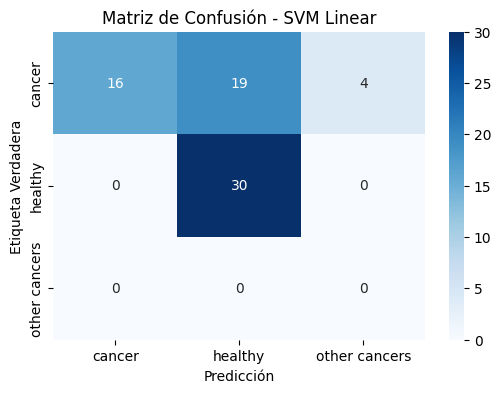

Evaluación del modelo SVM RBF en el conjunto reservado:
Modelo: SVM RBF, Accuracy: 0.4492753623188406, F1 Score: 0.4798900315650138, MCC: 0.4456422760373371
              precision    recall  f1-score   support

           0       1.00      0.08      0.14        39
           1       0.90      0.93      0.92        30
           2       0.00      0.00      0.00         0

    accuracy                           0.45        69
   macro avg       0.63      0.34      0.35        69
weighted avg       0.96      0.45      0.48        69

Matriz de confusión para SVM RBF:
[[ 3  3 33]
 [ 0 28  2]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


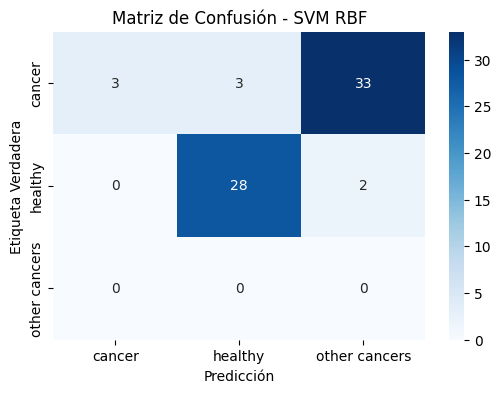

Evaluación del modelo Logistic Regression en el conjunto reservado:
Modelo: Logistic Regression, Accuracy: 0.5362318840579711, F1 Score: 0.5426235600148644, MCC: 0.13596954985480567
              precision    recall  f1-score   support

           0       0.57      0.74      0.64        39
           1       0.89      0.27      0.41        30
           2       0.00      0.00      0.00         0

    accuracy                           0.54        69
   macro avg       0.49      0.34      0.35        69
weighted avg       0.71      0.54      0.54        69

Matriz de confusión para Logistic Regression:
[[29  1  9]
 [22  8  0]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


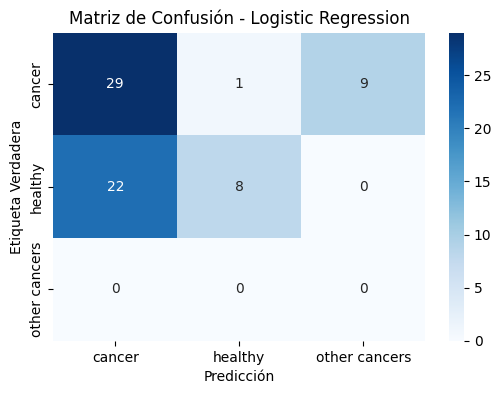

Evaluación del modelo Random Forest en el conjunto reservado:
Modelo: Random Forest, Accuracy: 0.43478260869565216, F1 Score: 0.2689376961004034, MCC: 0.07576627302822694
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.45      1.00      0.62        30
           2       0.00      0.00      0.00         0

    accuracy                           0.43        69
   macro avg       0.15      0.33      0.21        69
weighted avg       0.19      0.43      0.27        69

Matriz de confusión para Random Forest:
[[ 0 37  2]
 [ 0 30  0]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/li

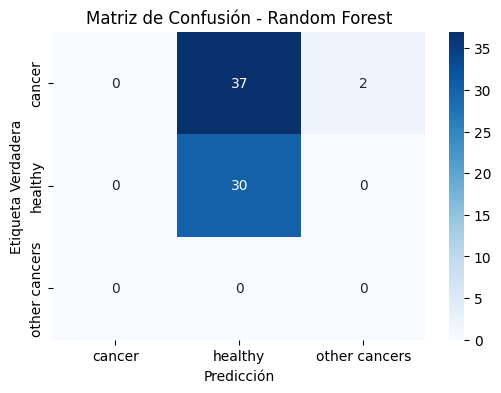

Evaluación del modelo Boosting en el conjunto reservado:
Modelo: Boosting, Accuracy: 0.43478260869565216, F1 Score: 0.2717391304347826, MCC: 0.09349469900084571
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.45      1.00      0.62        30
           2       0.00      0.00      0.00         0

    accuracy                           0.43        69
   macro avg       0.15      0.33      0.21        69
weighted avg       0.20      0.43      0.27        69

Matriz de confusión para Boosting:
[[ 0 36  3]
 [ 0 30  0]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/li

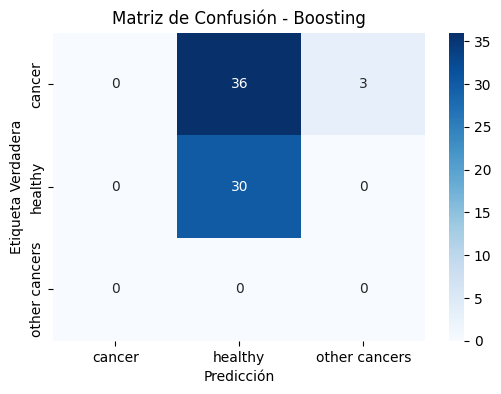

Evaluación del modelo Neural Network en el conjunto reservado:
Modelo: Neural Network, Accuracy: 0.43478260869565216, F1 Score: 0.2835538752362949, MCC: 0.14735046253382786
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        39
           1       0.48      1.00      0.65        30
           2       0.00      0.00      0.00         0

    accuracy                           0.43        69
   macro avg       0.16      0.33      0.22        69
weighted avg       0.21      0.43      0.28        69

Matriz de confusión para Neural Network:
[[ 0 32  7]
 [ 0 30  0]
 [ 0  0  0]]


/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/sespinoza/.venv/li

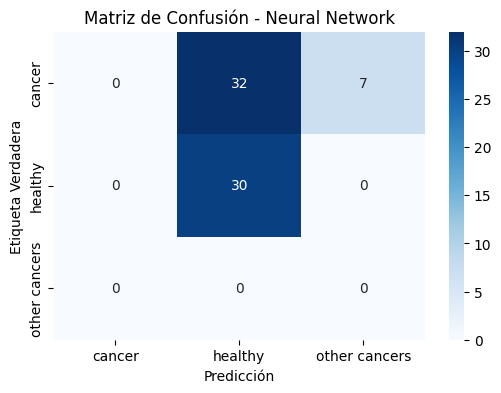

Modelo: SVM Linear, Accuracy: 0.6666666666666666, F1 Score: 0.6590683944563968, MCC: 0.4885967564883422
Modelo: SVM RBF, Accuracy: 0.4492753623188406, F1 Score: 0.4798900315650138, MCC: 0.4456422760373371
Modelo: Logistic Regression, Accuracy: 0.5362318840579711, F1 Score: 0.5426235600148644, MCC: 0.13596954985480567
Modelo: Random Forest, Accuracy: 0.43478260869565216, F1 Score: 0.2689376961004034, MCC: 0.07576627302822694
Modelo: Boosting, Accuracy: 0.43478260869565216, F1 Score: 0.2717391304347826, MCC: 0.09349469900084571
Modelo: Neural Network, Accuracy: 0.43478260869565216, F1 Score: 0.2835538752362949, MCC: 0.14735046253382786


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# **Evaluación en el Conjunto Reservado**

# Preprocesar el conjunto reservado
#X_reserved = microarray_data_common.drop('labels', axis=1)
#y_reserved = microarray_data_common['labels']
#y_reserved_encoded = label_encoder.transform(y_reserved)

X_reserved = data_peru.drop('labels', axis=1)
y_reserved_encoded = data_peru['labels']
# Escalar las características
X_reserved_scaled = min_max_scaler.transform(X_reserved)
X_reserved_scaled = pd.DataFrame(X_reserved_scaled, columns=X_reserved.columns)

# Selección de características
X_reserved_mi = X_reserved_scaled.iloc[:, selected_scores_indices]
X_reserved_final = rfe.transform(X_reserved_mi)
#X_reserved_final = selection.transform(X_reserved_selected)

#X_reserved_final = pca.transform(X_reserved_final_1)

# Evaluar los modelos
for name, model in final_models.items():
    print(f"Evaluación del modelo {name} en el conjunto reservado:")
    if name == 'Neural Network':
        y_pred_reserved = predict_pytorch(model, X_reserved_final)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")
    print(classification_report(y_reserved_encoded, y_pred_reserved))

    # Calcular la matriz de confusión
    cm_reserved = confusion_matrix(y_reserved_encoded, y_pred_reserved)

    # Mostrar la matriz de confusión
    print(f"Matriz de confusión para {name}:")
    print(cm_reserved)
    custom_labels = ['cancer', 'healthy','other cancers']
    # Visualizar la matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_reserved, annot=True, fmt='d', cmap='Blues', xticklabels=custom_labels, yticklabels=custom_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


for name, model in final_models.items():
    if name == 'Neural Network':
        y_pred_reserved = predict_pytorch(model, X_reserved_final)
    else:
        y_pred_reserved = model.predict(X_reserved_final)
    # Calcular y mostrar las métricas
    acc_reserved = accuracy_score(y_reserved_encoded, y_pred_reserved)
    f1_reserved = f1_score(y_reserved_encoded, y_pred_reserved, average='weighted')
    mcc_reserved = matthews_corrcoef(y_reserved_encoded, y_pred_reserved)
    print(f"Modelo: {name}, Accuracy: {acc_reserved}, F1 Score: {f1_reserved}, MCC: {mcc_reserved}")